In [3]:
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, explode, length, to_json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
from datetime import datetime

# Charger les variables d'environnement
load_dotenv()

# Configuration des graphiques
plt.style.use('default')  # Style par défaut
sns.set_theme()  # Configuration de base de seaborn
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [4]:
# Configuration de Spark
storage_account_name = os.getenv("AZURE_STORAGE_ACCOUNT_NAME")
storage_account_key = os.getenv("AZURE_STORAGE_ACCOUNT_KEY")
container_name = os.getenv("AZURE_CONTAINER_NAME")

if not all([storage_account_name, storage_account_key, container_name]):
    raise ValueError("❌ ERREUR : Variables d'environnement Azure manquantes")

# Chemin vers les fichiers JAR Hadoop et Azure
hadoop_jars_path = os.path.expanduser("~/hadoop_jars")
jars = [
    f"{hadoop_jars_path}/hadoop-azure-3.3.1.jar",
    f"{hadoop_jars_path}/azure-storage-8.6.6.jar",
    f"{hadoop_jars_path}/jetty-util-9.4.40.v20210413.jar",
    f"{hadoop_jars_path}/jetty-util-ajax-9.4.40.v20210413.jar"
]

spark = SparkSession.builder \
    .appName("ParquetAnalysis") \
    .master("local[*]") \
    .config("spark.jars", ",".join(jars)) \
    .config("spark.hadoop.fs.azure", "org.apache.hadoop.fs.azure.NativeAzureFileSystem") \
    .config(f"spark.hadoop.fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key) \
    .config("spark.hadoop.fs.azure.account.auth.type", "SharedKey") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

print("✅ Spark configuré avec succès !")

your 131072x1 screen size is bogus. expect trouble
25/03/19 09:48:49 WARN Utils: Your hostname, DESKTOP-G3B8R0F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/19 09:48:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/19 09:48:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Spark configuré avec succès !


In [5]:
# Chargement des données Parquet
parquet_folder = "data/"
azure_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/{parquet_folder}"
print(f"📂 Lecture des fichiers Parquet depuis : {azure_url}")

df = spark.read.parquet(azure_url)
print(f"✅ Données chargées : {df.count():,} lignes")

# Aperçu des données
print("\n📊 Aperçu des données :")
df.show(5, truncate=False)

📂 Lecture des fichiers Parquet depuis : wasbs://fichiers-parquet@darija.blob.core.windows.net/data/


25/03/19 09:48:51 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-azure-file-system.properties,hadoop-metrics2.properties


✅ Données chargées : 458,285 lignes

📊 Aperçu des données :


25/03/19 09:49:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

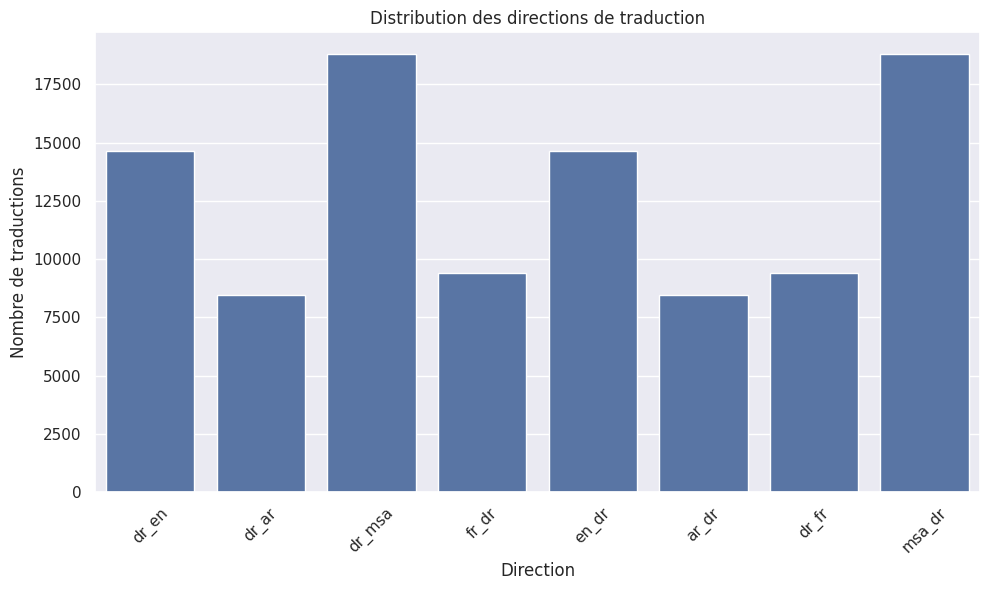


📊 Statistiques des directions :


,direction,count
0,dr_en,14637
1,dr_ar,8460
2,dr_msa,18797
3,None,355703
4,fr_dr,9397
5,en_dr,14637
6,ar_dr,8460
7,dr_fr,9397
8,msa_dr,18797


In [6]:
# Analyse des directions de traduction
direction_counts = df.groupBy("direction").count().toPandas()

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=direction_counts, x="direction", y="count")
plt.title("Distribution des directions de traduction")
plt.xlabel("Direction")
plt.ylabel("Nombre de traductions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistiques
print("\n📊 Statistiques des directions :")
display(direction_counts)

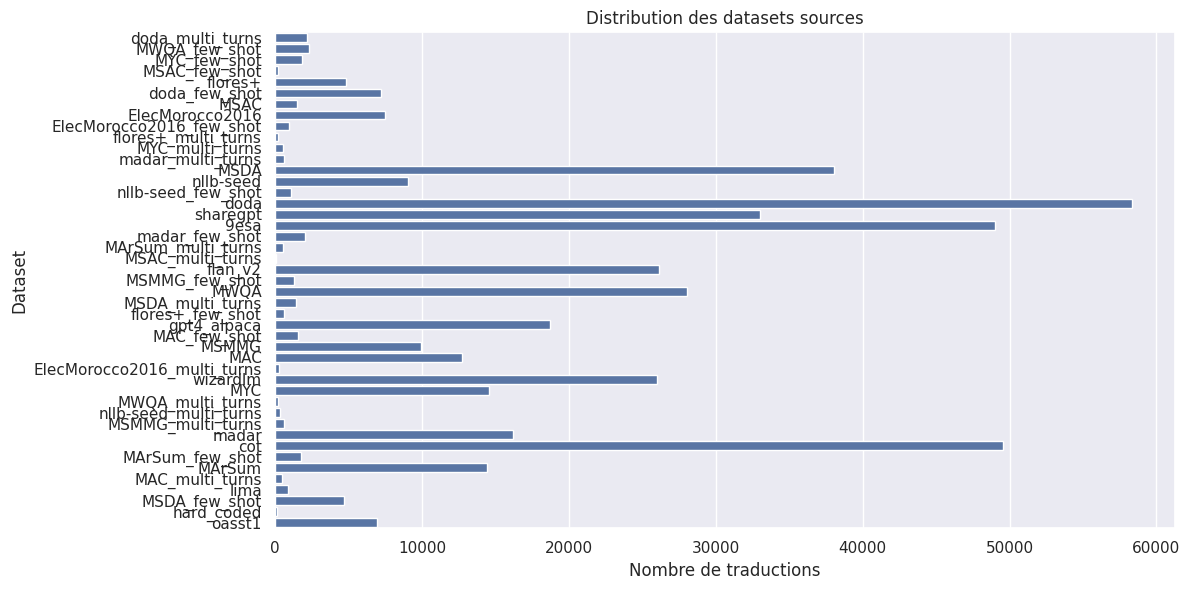


📊 Statistiques des datasets :


,dataset,count
0,doda_multi_turns,2160
1,MWQA_few_shot,2314
2,MYC_few_shot,1799
3,MSAC_few_shot,180
4,flores+,4842
5,doda_few_shot,7200
6,MSAC,1458
7,ElecMorocco2016,7476
8,ElecMorocco2016_few_shot,923
9,flores+_multi_turns,180


In [7]:
# Analyse des datasets sources
dataset_counts = df.groupBy("dataset").count().toPandas()

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(data=dataset_counts, y="dataset", x="count")
plt.title("Distribution des datasets sources")
plt.xlabel("Nombre de traductions")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

# Statistiques
print("\n📊 Statistiques des datasets :")
display(dataset_counts)

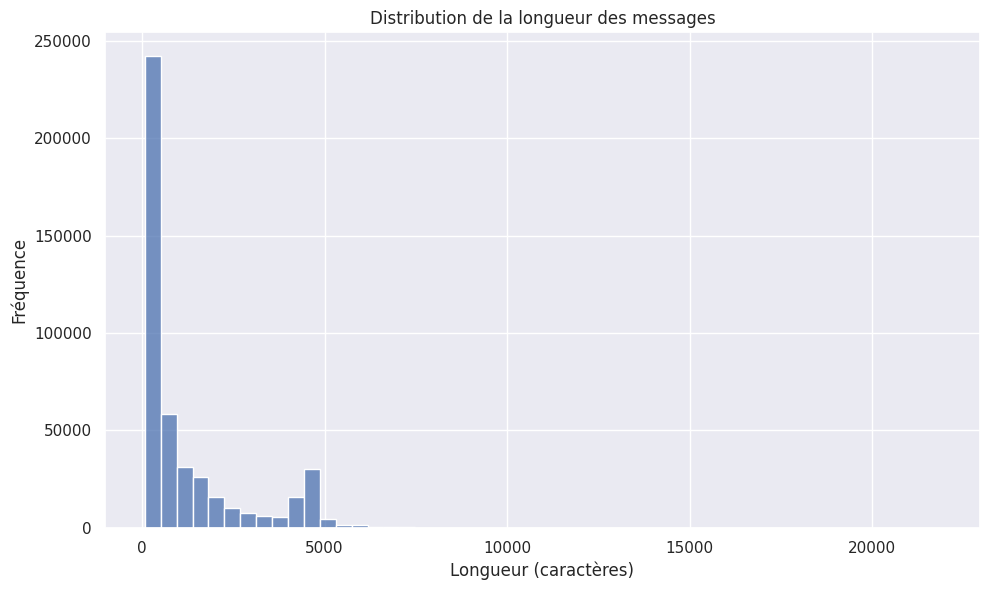


📊 Statistiques des longueurs de messages :


,summary,message_length
0,count,458285
1,mean,1206.6438220757825
2,stddev,1505.2418680175156
3,min,74
4,max,21865


In [8]:
# Conversion des messages en JSON pour l'analyse
df_with_json = df.withColumn("messages_json", to_json(col("messages")))

# Analyse de la longueur des messages
message_lengths = df_with_json.select(length(col("messages_json")).alias("message_length"))
length_stats = message_lengths.describe().toPandas()

# Visualisation
plt.figure(figsize=(10, 6))
sns.histplot(data=message_lengths.toPandas(), x="message_length", bins=50)
plt.title("Distribution de la longueur des messages")
plt.xlabel("Longueur (caractères)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# Statistiques
print("\n📊 Statistiques des longueurs de messages :")
display(length_stats)

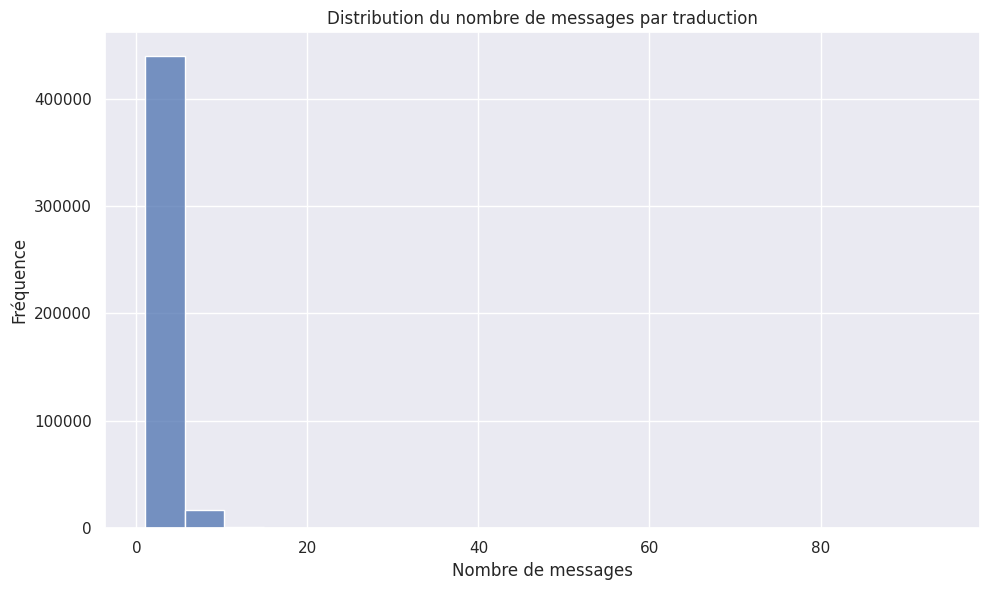


📊 Statistiques sur le nombre de messages :


,summary,nb_messages
0,count,458285
1,mean,2.2705390750297303
2,stddev,1.35589072743812
3,min,1
4,max,94


In [10]:
# Analyse détaillée des messages
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def analyze_message_content(messages):
    try:
        messages_list = json.loads(messages)
        return len(messages_list)
    except:
        return 0

# Ajout du nombre de messages par traduction
df_with_counts = df_with_json.withColumn(
    "nb_messages",
    udf(analyze_message_content, IntegerType())("messages_json")
)

# Statistiques sur le nombre de messages
message_count_stats = df_with_counts.select("nb_messages").describe().toPandas()

# Visualisation
plt.figure(figsize=(10, 6))
sns.histplot(data=df_with_counts.select("nb_messages").toPandas(), x="nb_messages", bins=20)
plt.title("Distribution du nombre de messages par traduction")
plt.xlabel("Nombre de messages")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# Statistiques
print("\n📊 Statistiques sur le nombre de messages :")
display(message_count_stats)

In [ ]:
# Arrêt de la session Spark
spark.stop()